## Background
We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification, and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal, we are working on designing an ever-evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

## Data

The data comes from the direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case, a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

### Features:

    • age: age of customer (numeric)
    • job: type of job (categorical)
    • marital: marital status (categorical)
    • education: (categorical)
    • default: has credit in default? (binary)
    • balance: average yearly balance, in euros (numeric)
    • housing: has a housing loan? (binary)
    • loan: has a personal loan? (binary)
    • contact: contact communication type (categorical)
    • day: last contact day of the month (numeric)
    • month: last contact month of the year (categorical)
    • duration: last contact duration, in seconds (numeric)
    • campaign: number of contacts performed during this campaign and for this client (numeric, includes the last contact)
    
### Target:

    • y - has the client subscribed to a term deposit? (binary)

## Goal(s):

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

### Success Metric(s):
**Hit %81** or above accuracy by evaluating with **5-fold** cross-validation and reporting the average performance score.

### Bonus(es):
- We are also interested in finding customers who are **more likely** to buy the investment product. Determine the **segment(s)** of customers our client should prioritize.
- What makes the customers buy? Tell us **which feature** we should be focusing more on.

## 0. Import the necessary libraries

In [1]:
# To ignore warnings
import warnings

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# Set a seed value
seed_value= 42

# # Report it that number to your experiment tracking system.
# experiment = Experiment(project_name=”Classification model”)
# experiment.log_other(“random seed”, seed_value)

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# # 5. For layers that introduce randomness like dropout, make sure to set seed values 
# model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


In [3]:
# loading in datasets
df = pd.read_csv('term-deposit-marketing-2020.csv')

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [6]:
# Checking summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


## **1. Initial Observations:**
- There are **40,000** observations and **13** columns.
- There are **no null values** in the data.
- There are **5 numerical** columns and the rest are **categorical**.
- The output **y** column is a categorical column containing yes or no indicating whether or not the customer has subscribed to a term loan.  We will use this column as our **label**. 

### Let's explore all the numerical columns

### **A. Exploring the Data Distribution**

In [7]:
# Creating a list of numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

age
Skew : 0.44


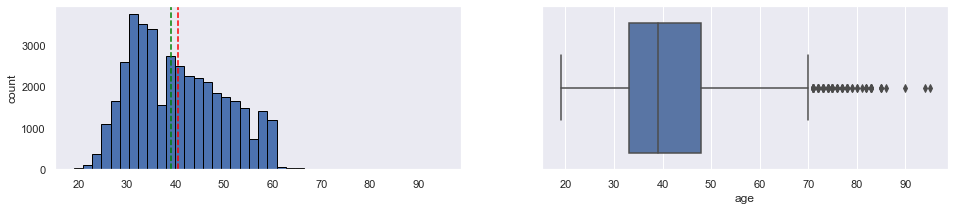

balance
Skew : 8.26


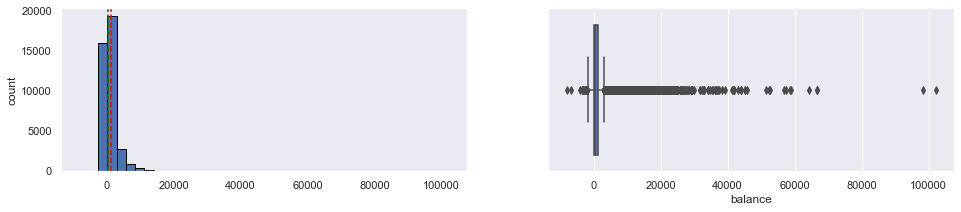

day
Skew : 0.07


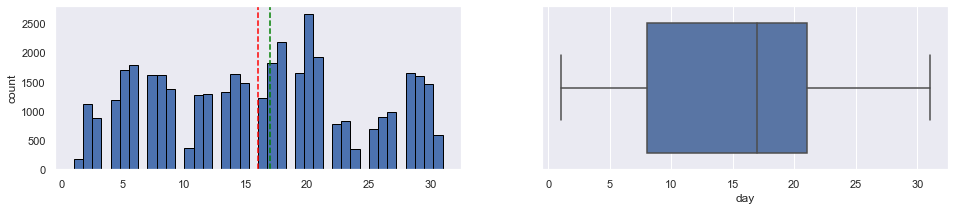

duration
Skew : 3.17


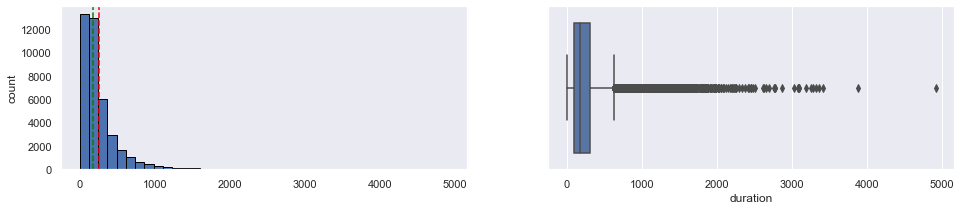

campaign
Skew : 4.73


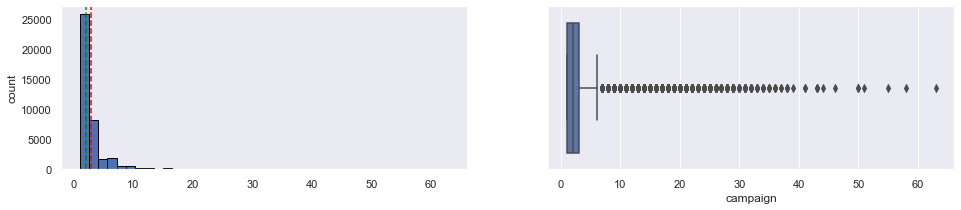

In [8]:
# Plotting a histogram and boxplot to check the distribution of our numerical data
sns.set(font_scale = 1)
cont_cols = list(df[num_cols])
for col in cont_cols:
    print(col)
    print('Skew :',round(df[col].skew(),2))
    plt.figure(figsize=(16,3))
    plt.subplot(1,2,1)
    df[col].hist(bins=40, grid=False, ec='black')
    plt.axvline(x = df[col].mean(), linestyle ="--", color ='red')
    plt.axvline(x = df[col].median(), linestyle ="--", color ='green')
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.show()

### **Key Observations:**
- The current **average age** of our clients are **around 40**.  There are a little bit of an outlier for clients over 70.
- Average balance tend to be on the low side at around 1,300 dollars but we have clients potential balances up to 100,000 dollars.  One question is **how can we increase** this average?
- We have a **huge skew** in call **duration** - average calls are **around 250** seconds, outliers start at around 750 seconds.  The question is **what percentage of conversions happen above 750** calls?  
- **Similarly**, there is a huge **skew in campaign** contacts, **averaging 3 contacts** per customers with outliers start around 7 contacts.  Again, we should look at **percentage of conversations above 7** contacts. 

### **B. Exploring the Conversion Rates across Different Catagories**

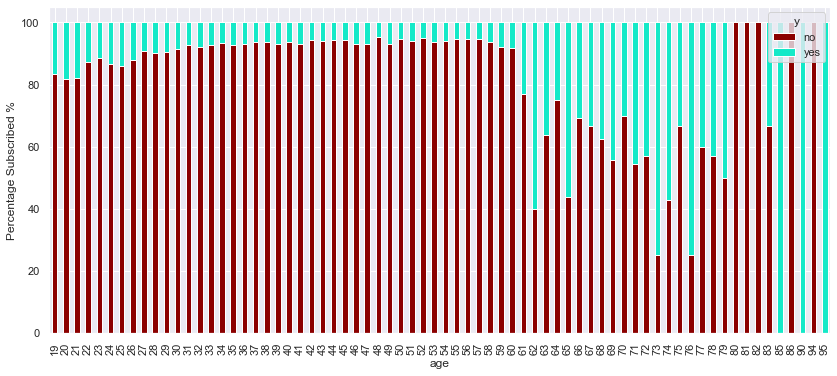

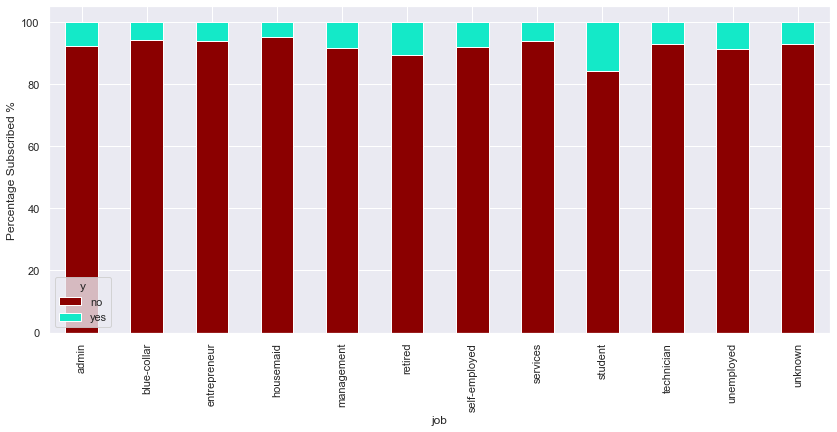

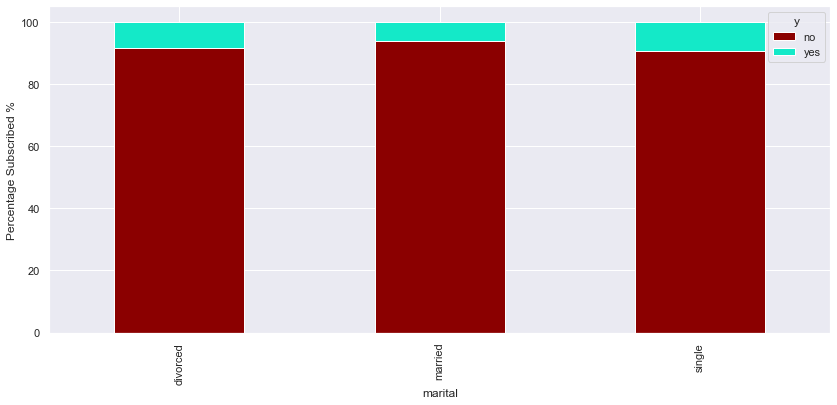

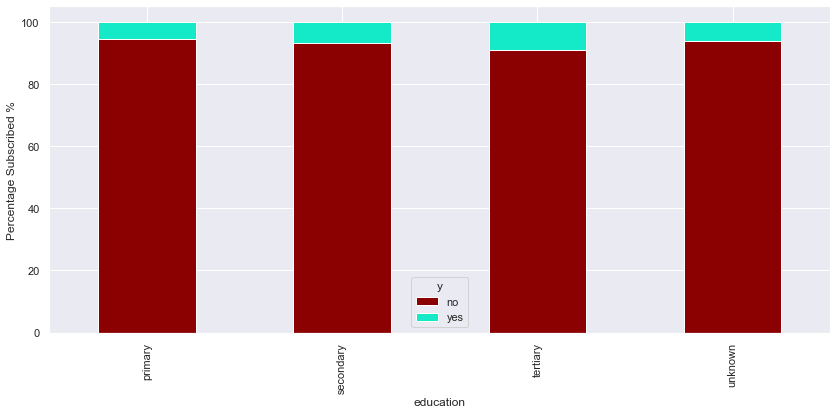

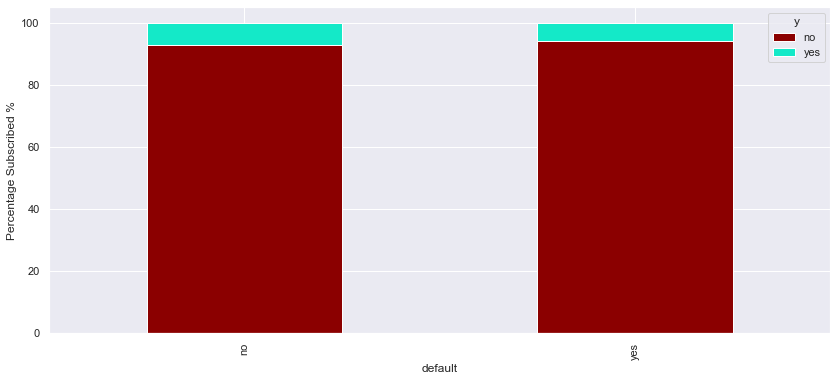

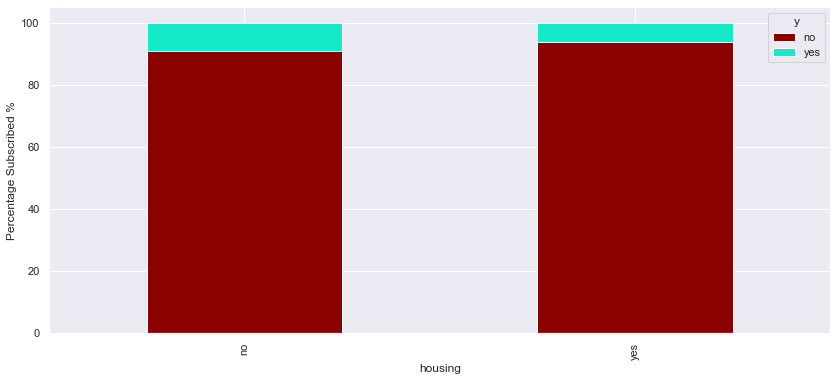

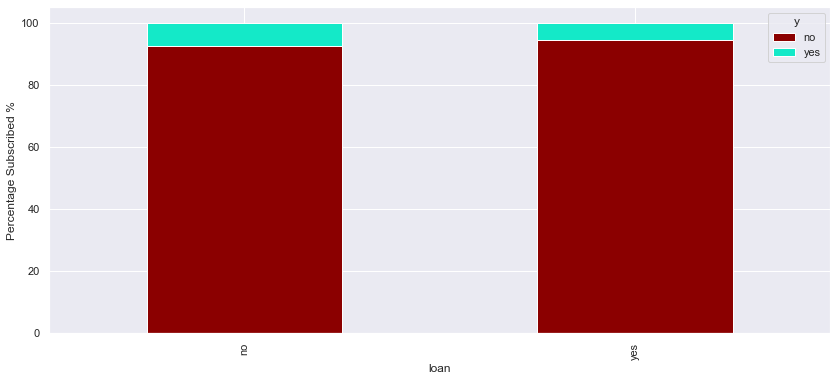

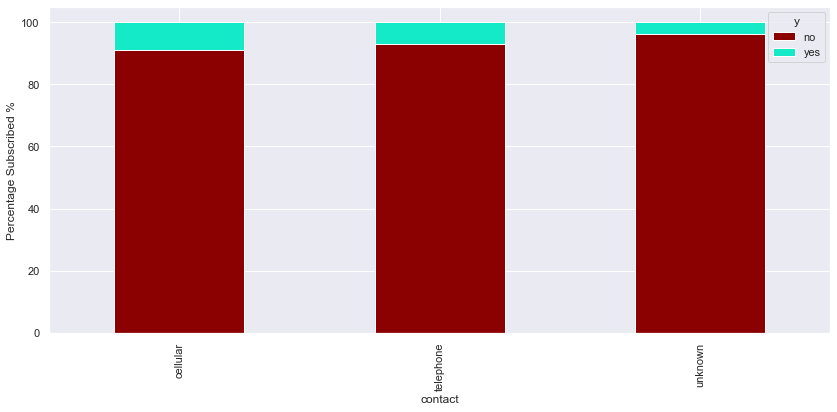

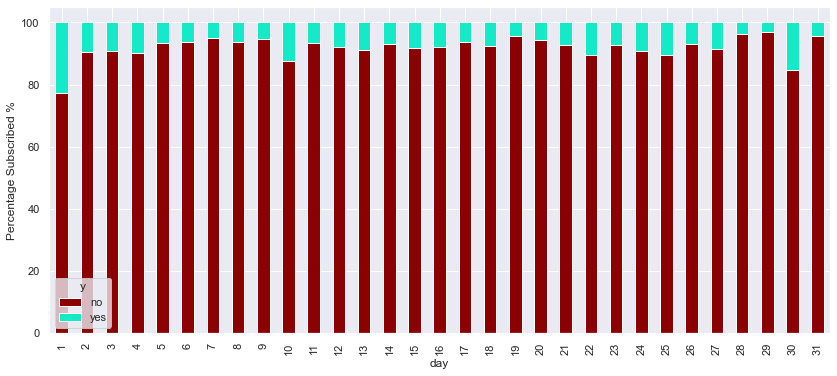

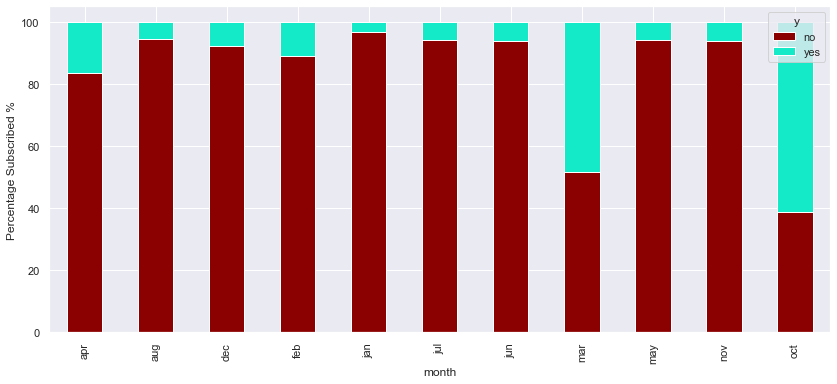

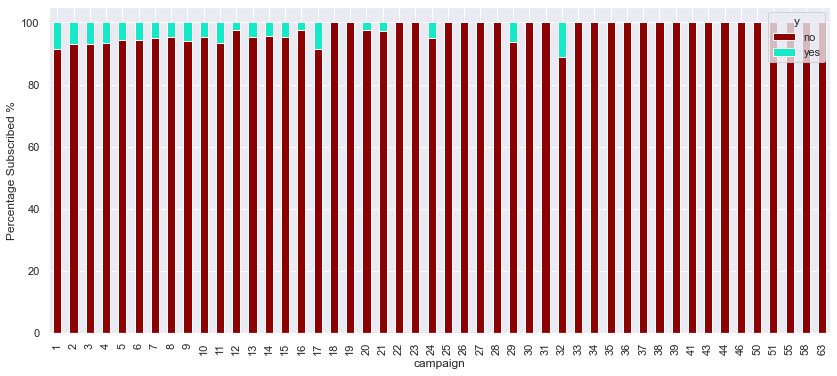

In [9]:
cols = df.columns
colors = ['#8B0000', '#14e9c8']
for i in cols:
    if i not in ['y', 'balance', 'duration']:
        (pd.crosstab(df[i], df['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                                color = colors)
        plt.ylabel('Percentage Subscribed %')
        

### **Key Observations:**
- We see **conversion rate** start to climb **over the age of 60** have a higher rate of apply for term loan.  
- There are higher conversion rates among those who **don't own homes** and who **don't have loans** - This makes sense because that they have more available money to commit to term deposits.
- **Students and Retirees** seem to have higher rates of conversion.  
- Interestingly, customers whose last month contacted in **March** or **October** have higher conversion rates. **Again**, these may again be explained as above that lower volumn skews that percentage higher or it could indicate an area to study to see if this group yields higher applicant rates.
- In terms of **how many contacts** during a campaign it seems that it's **no longer effective** after **30** contacts. The conversion rates begins to diminish after the 1st call and becomes almost non-existent after the 20th call except for some anomolies. The **recommendation is to stop** when the contact number reaches **20**.  

### **C. Exploring Call Duration**

In [10]:
# Counting up all subscribers
all_subscribers = df['y'].value_counts()[1]
all_subscribers

2896

In [11]:
# Counting number of subscribers obtained after 1500 second duration of calls
df_hdur_1 = df[df['duration'] > 1500]
subscriber_hdur_1 = df_hdur_1['y'].value_counts()[1]
subscriber_hdur_1

76

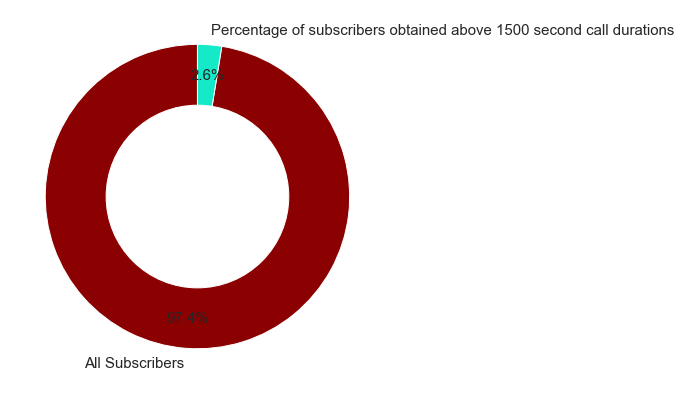

In [12]:
# Graphing our labelled categories
category_names = ['All Subscribers', 'Percentage of subscribers obtained above 1500 second call durations']
sizes = [all_subscribers, subscriber_hdur_1]

plt.figure(figsize = (7, 7))
plt.pie(sizes, labels = category_names, textprops = {'fontsize': 15}, startangle=90, 
        autopct='%1.1f%%', colors = colors, pctdistance=0.8)

center_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

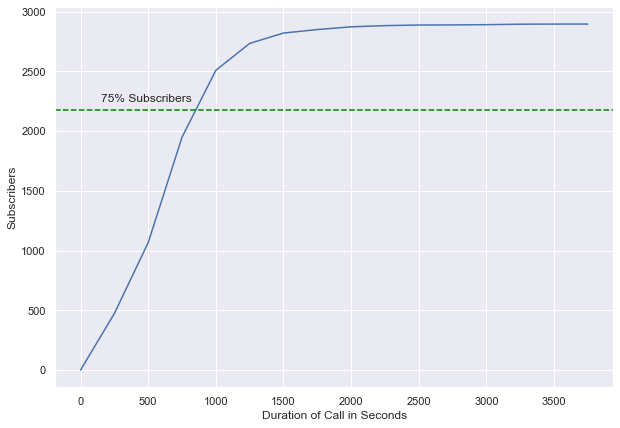

In [13]:
total_subscribers = df['y'].value_counts()[1].max()
duration = []
subscribers = []
sub_remainder = []
sub_percentage = []
cummulative_sub = []
num_sub = []

for i in range(0, 4000, 250):
    
    dur = df[df['duration'] > i]
    subs_rem = dur['y'].value_counts()[1]
    subs_dur = (total_subscribers - subs_rem) / total_subscribers # Percentage of Subscribers remaining
    duration.append(i)
    sub_remainder.append(subs_dur) # Percentage of Subscribers remaining
    subscribers.append(subs_rem)
    cummulative_sub.append(total_subscribers - subs_rem)
    num_sub.append(subscribers)
    
    
  
plt.figure(figsize=(10,7))
plt.plot(duration, cummulative_sub)
plt.xlabel('Duration of Call in Seconds')
plt.ylabel('Subscribers')
#plt.axvline(x = 1000, linestyle ="--", color ='red')

dur = df[df['duration'] > 1500]
plt.axhline(y = (total_subscribers * .75), linestyle ="--", color ='green')
plt.text(150, 2250, "75% Subscribers")
plt.show()


### **Key Observations:**
- The **number of conversions** starts to **taper off after** call duration of **1000 seconds** and even more after 1500 seconds. We could see that **75% of all of our subscription** is obtained **before we reach the 1000 second mark**.  Calls after 1500 seconds account for **only 4.2%** of our total conversion rate.  
- We noted earlier that the **average calls** lasts only **255 seconds** and **75%** of our calls lasts **only 315** seconds.  **However, at 250 seconds** we only captured **16%** of our total subscribers.  Also, we see in the plot below that we get our **largest number** of suscribers at **500 to 750 seconds** duration and our **3rd largest suscribers** between **750 to 1000 seconds** duration.
- **Our recommendation** is to aim for call durations of **around 750** seconds **but no more than 1000 seconds**.  After 1000 seconds, we have already captured at least 80% of our total subscribers.  

In [14]:
# Looking at call duration
call_duration = pd.DataFrame(zip(duration, cummulative_sub, sub_remainder), columns=['call duration', 'subscribers', '% subscribers'])
call_duration['total sub'] = call_duration['subscribers'] - (call_duration['subscribers'].shift(1, axis=0))
call_duration = call_duration.replace(np.nan, 0)
call_duration['total sub'] = call_duration['total sub'].astype(np.int64)
call_duration = call_duration.drop('subscribers', axis = 1)
call_duration

,call duration,% subscribers,total sub
0,0,0.000000,0
1,250,0.163329,473
2,500,0.368094,593
3,750,0.672652,882
4,1000,0.866022,560
5,1250,0.943715,225
6,1500,0.973757,87
7,1750,0.983771,29
8,2000,0.991713,23
9,2250,0.995166,10


Text(0, 0.5, 'Number of Subscribers')

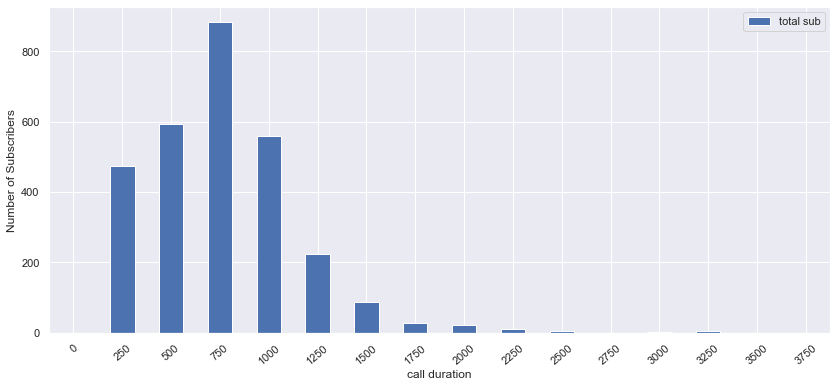

In [15]:
# Plotting call duration
call_duration.plot.bar(x = 'call duration', y = 'total sub', rot = 40, figsize=(14,6))
plt.ylabel("Number of Subscribers")

### **D. Exploring Campaign outreach and balance**

<AxesSubplot:xlabel='month'>

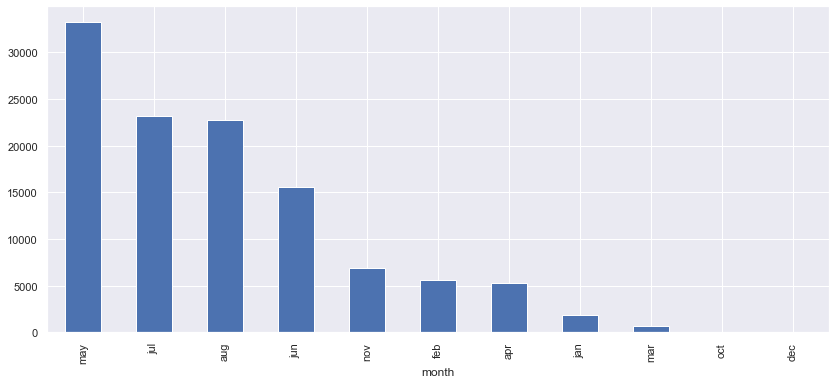

In [16]:
# Checking the total compaigns per month
df.groupby('month')['campaign'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='month'>

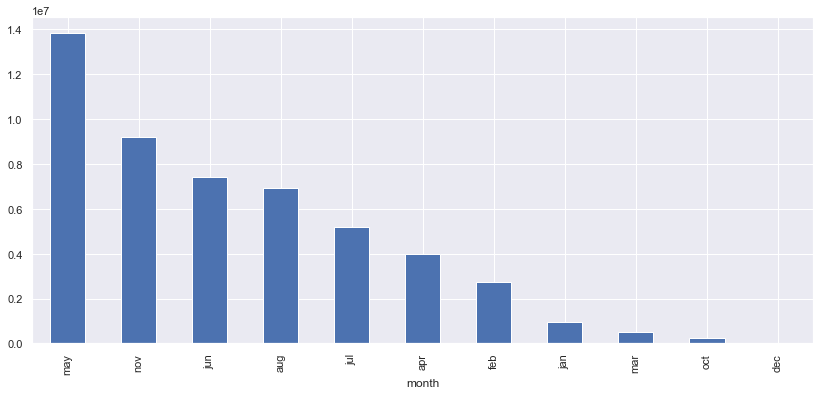

In [17]:
# Checking the balance total per month last contact
df.groupby('month')['balance'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='month'>

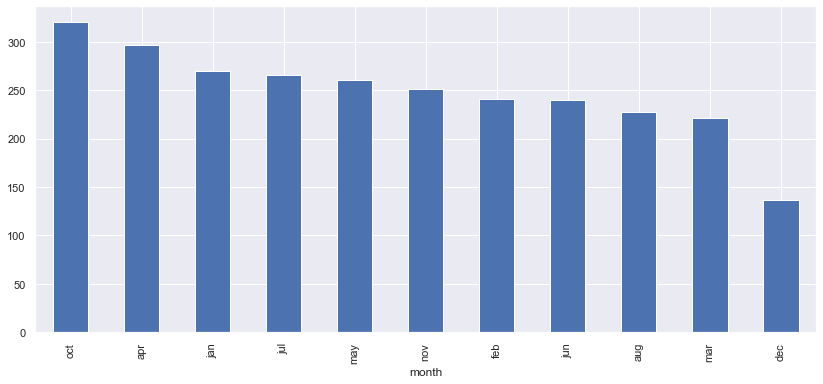

In [18]:
df.groupby('month')['duration'].mean().sort_values(ascending=False).plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='day'>

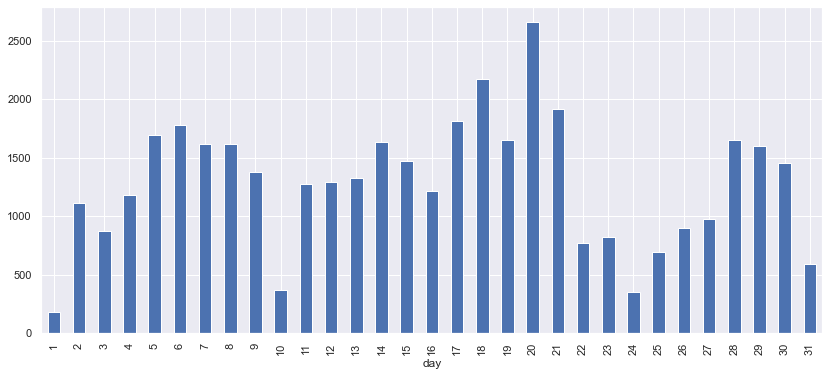

In [19]:
df.groupby('day')['campaign'].count().plot(kind='bar',figsize=(14,6))

- Total number of campaigns seem to correlate with balance amount.  The largest total balances months correspond with how much campaigning is done that month. However, it doesn't correspond with the conversion for the loan. So it doens't tell us much.  

### **E. Feature Engineering and Prepping the Data for Modelling**

In [20]:
# Checking our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [21]:
# Converting our Data for Machine Learning
df_num = df

In [22]:
# mapping our categorical columns to numbers
dict_education = {'tertiary': 3, 'secondary':2, 'primary':1, 'unknown':0}
dict_default = {'yes': 1, 'no':0}
dict_housing = {'yes': 1, 'no':0}
dict_loan = {'yes': 1, 'no':0}
dict_target = {'yes': 1, 'no': 0}

df_num['education'] = df_num.education.map(dict_education)
df_num['default'] = df_num.default.map(dict_default)
df_num['housing'] = df_num.housing.map(dict_housing)
df_num['loan'] = df_num.loan.map(dict_loan)
df_num['y'] = df_num.y.map(dict_target)

In [23]:
# Let's create a column that combines our age groups into decades 
bins = [19, 20, 30, 40, 50, 60, 70, 80, 90]
age_range = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+']

d = dict(enumerate(age_range, 1))

df['AgeRange'] = np.vectorize(d.get)(np.digitize(df['age'], bins))

In [24]:
# Let's create a column that combines balances 
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
balance_range = ['<10k', '10-20k', '20-30k', '30-40k', '40-50k', '50-60k', '60-70k', '70-80k', '80-90k', '90-100k', '100+']

d = dict(enumerate(balance_range, 1))

df_num['balance_range'] = np.vectorize(d.get)(np.digitize(df_num['balance'], bins))

In [25]:
# Let's create a column that combines call durations
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
duration_range = ['<.5k', '.5-1k', '1-1.5k', '1.5-2k', '2-2.5k', '2.5-3k', '3-3.5k', '3.5-4k', '4-4.5k', '4.5-5k', '5k+']

d = dict(enumerate(duration_range, 1))

df_num['duration_range'] = np.vectorize(d.get)(np.digitize(df_num['duration'], bins))

In [26]:
df_num.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,AgeRange,balance_range,duration_range
0,58,management,married,3,0,2143,1,0,unknown,5,may,261,1,0,50-60,<10k,<.5k
1,44,technician,single,2,0,29,1,0,unknown,5,may,151,1,0,40-50,<10k,<.5k
2,33,entrepreneur,married,2,0,2,1,1,unknown,5,may,76,1,0,30-40,<10k,<.5k
3,47,blue-collar,married,0,0,1506,1,0,unknown,5,may,92,1,0,40-50,<10k,<.5k
4,33,unknown,single,0,0,1,0,0,unknown,5,may,198,1,0,30-40,<10k,<.5k


<AxesSubplot:xlabel='AgeRange'>

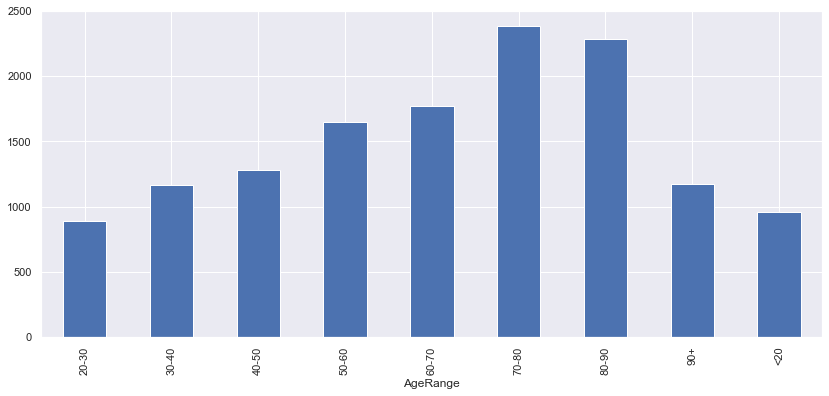

In [27]:
df_num.groupby('AgeRange')['balance'].mean().plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='AgeRange'>

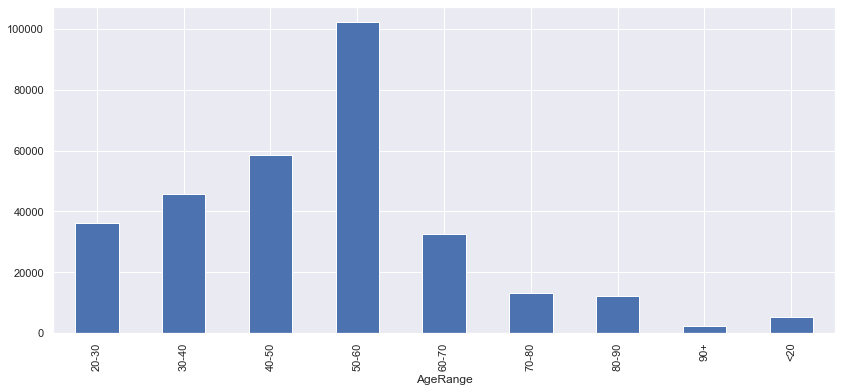

In [28]:
df_num.groupby('AgeRange')['balance'].max().plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='AgeRange'>

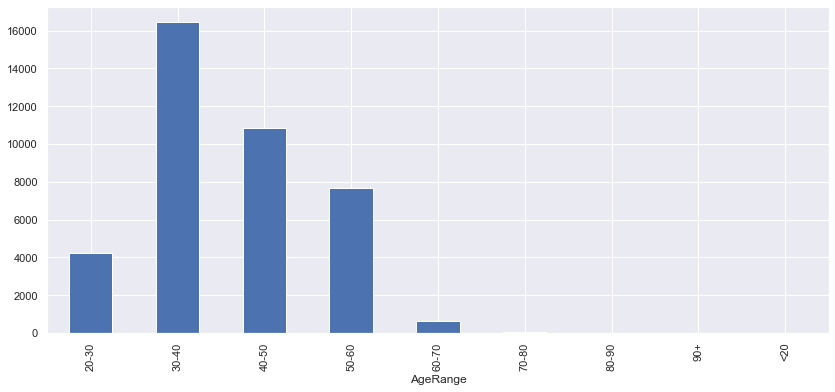

In [29]:
df_num.groupby('AgeRange')['balance'].count().plot(kind='bar',figsize=(14,6))

<AxesSubplot:xlabel='day'>

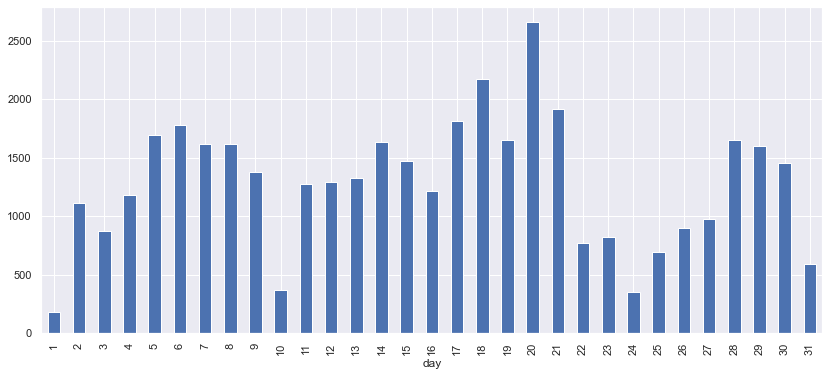

In [30]:
df_num.groupby('day')['campaign'].count().plot(kind='bar',figsize=(14,6))

Text(0, 0.5, 'Percentage Subscribed %')

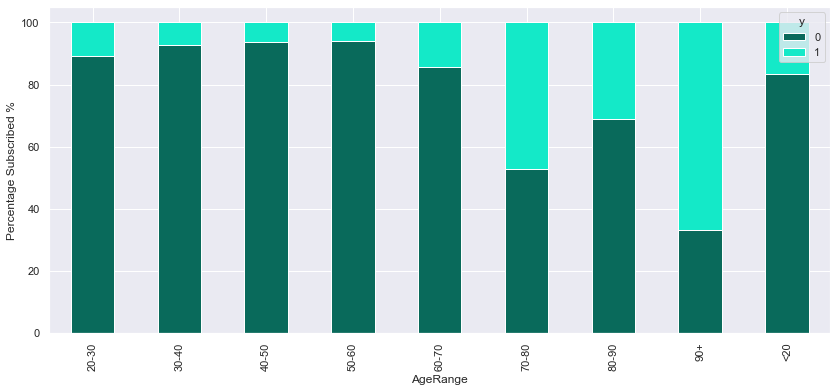

In [31]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df['AgeRange'],df['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

Text(0, 0.5, 'Percentage Subscribed %')

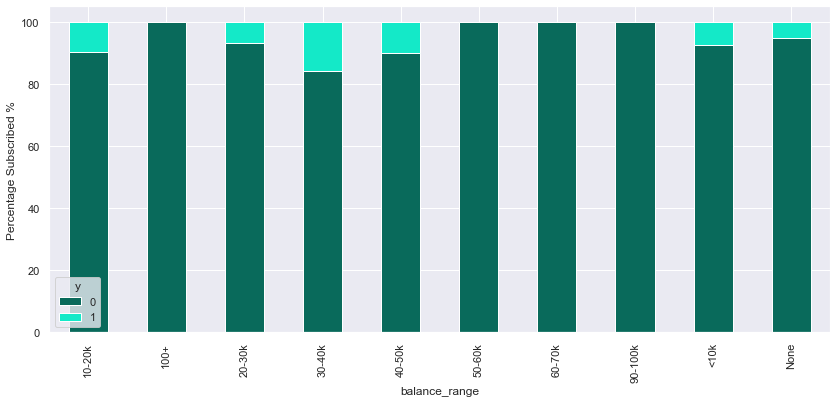

In [32]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df_num['balance_range'],df_num['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

Text(0, 0.5, 'Percentage Subscribed %')

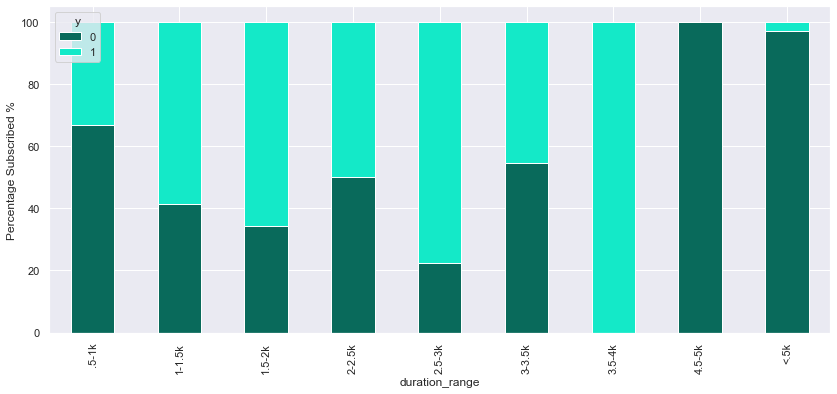

In [33]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df_num['duration_range'],df_num['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

In [34]:
df.nunique()

age                 70
job                 12
marital              3
education            4
default              2
balance           6849
housing              2
loan                 2
contact              3
day                 31
month               11
duration          1535
campaign            48
y                    2
AgeRange             9
balance_range       10
duration_range       9
dtype: int64

Text(0, 0.5, 'Percentage Subscribed %')

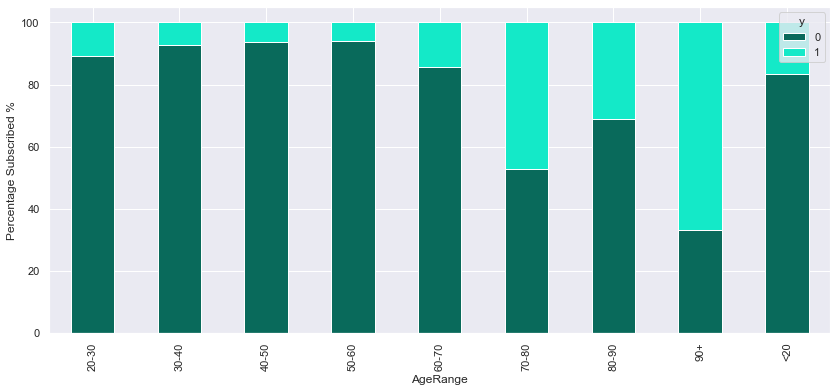

In [35]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df['AgeRange'],df['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

Text(0, 0.5, 'Percentage Subscribed %')

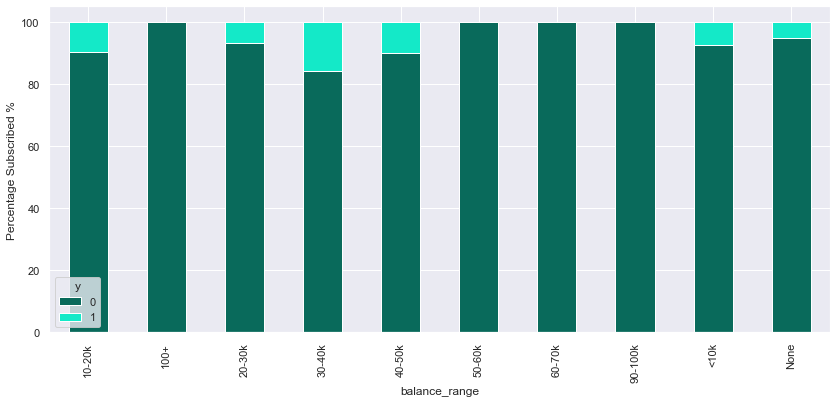

In [36]:
colors = ['#096a5b', '#14e9c8']

(pd.crosstab(df['balance_range'],df['y'],normalize='index')*100).plot(kind='bar',figsize=(14,6),stacked=True, 
                                                        color = colors)
plt.ylabel('Percentage Subscribed %')

In [37]:
df_num.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,AgeRange,balance_range,duration_range
39995,53,technician,married,3,0,395,0,0,cellular,3,jun,107,1,0,50-60,<10k,<.5k
39996,30,management,single,3,0,3340,0,0,cellular,3,jun,238,3,1,30-40,<10k,<.5k
39997,54,admin,divorced,2,0,200,0,0,cellular,3,jun,170,1,1,50-60,<10k,<.5k
39998,34,management,married,3,0,1047,0,0,cellular,3,jun,342,1,0,30-40,<10k,<.5k
39999,38,technician,married,2,0,1442,1,0,cellular,3,jun,113,1,0,30-40,<10k,<.5k


In [38]:
# Counting the Total Number of Applicants per age group
df_num[df_num['y'] == 1].groupby(['AgeRange','y']).size().reset_index(name='count')

,AgeRange,y,count
0,20-30,1,463
1,30-40,1,1181
2,40-50,1,671
3,50-60,1,448
4,60-70,1,91
5,70-80,1,33
6,80-90,1,5
7,90+,1,2
8,<20,1,2


In [39]:
df.nunique()

age                 70
job                 12
marital              3
education            4
default              2
balance           6849
housing              2
loan                 2
contact              3
day                 31
month               11
duration          1535
campaign            48
y                    2
AgeRange             9
balance_range       10
duration_range       9
dtype: int64

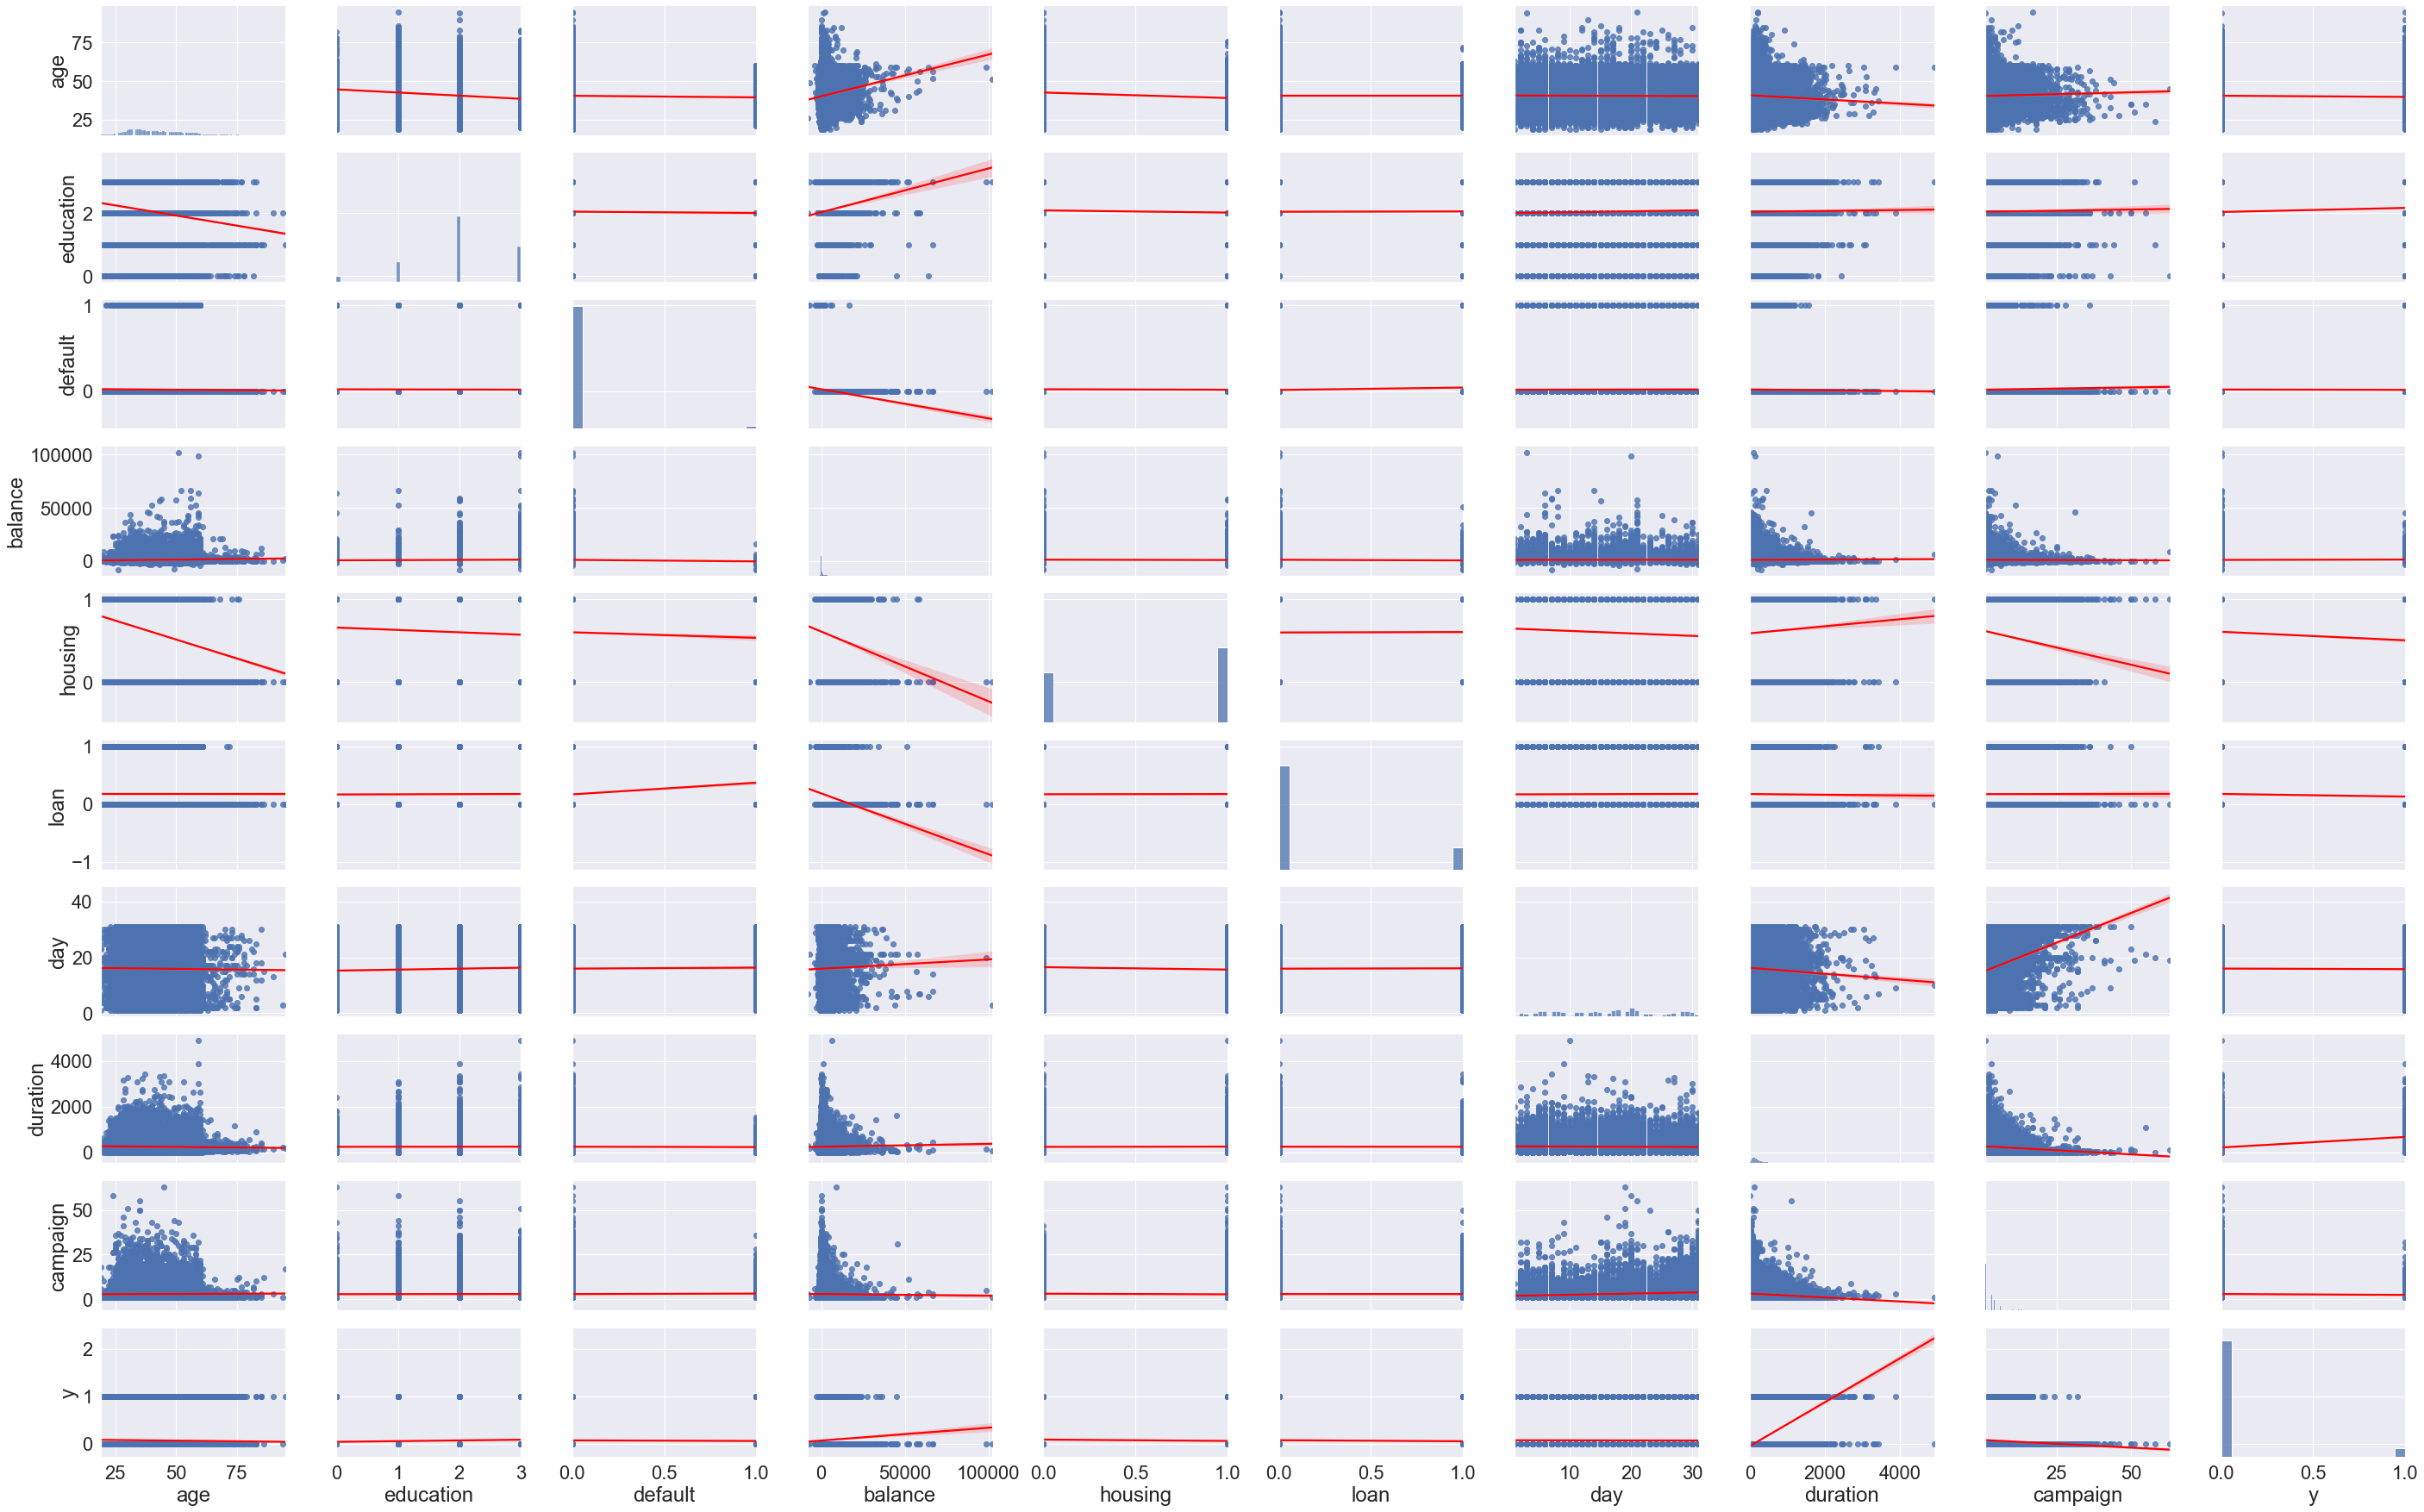

In [40]:
data = df_num
sns.set(font_scale = 2)
sns.pairplot(data, kind="reg", aspect=16/10, plot_kws={'line_kws':{'color':'red'}})
plt.show()

In [41]:
# Creating a mask to mask off top half of correlation heatmap
mask = np.zeros_like(df_num.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

<AxesSubplot:>

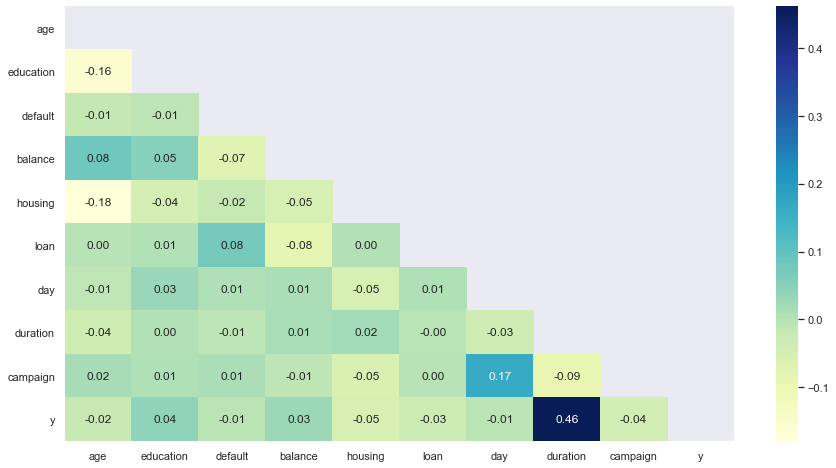

In [42]:
# plotting the correation between numerical variables
sns.set(font_scale = 1)
plt.figure(figsize=(15,8))
sns.heatmap(df_num.corr(),annot=True, fmt='0.2f', cmap='YlGnBu', mask=mask)

**Observations:**
- We have an **highly imbalanced class** of applicant verse non-applicants, as typical in these studies.  We will need to adjust for this when we build our models later.
- Percentage wise it looks like people **over the age of 60** have a higher rate of apply for term loan.  But our distribution of customers show that we don't have as many customers over 60 - so even though it's a higher percentage, it only accounts of a smaller number of applicants in comparison.   
- It **may be** that if we add more customers above 60, it may bring in more applicants or it could mean that as we bring in more customers above 60, the application percentage will begin to match the other age groups.  This could be an area to research.
- There are higher percentage of applicants among those who **don't own homes** and who **don't have loans** - it's possible that these have more available money to save.
- **Students and Retirees** seem to have higher percentage rates of term loan applicants.  
- Also customers whose last month contacted in **March** or **October** have higher applicant rate. **Again**, these may again be explained as above that lower volumn skews that percentage higher or it could indicate an area to study to see if this group yields higher applicant rates.
- In terms of **how many contacts** during a campaign it seems that it's **no longer effective** after **30** contacts.  

## 2. Building our Models

### Let's Look Label Class Distribution

In [43]:
# Getting a count of churn column
df_num['y'].value_counts()

0    37104
1     2896
Name: y, dtype: int64

In [44]:
non_subscriber = df_num['y'].value_counts()[0]
subscriber = df_num['y'].value_counts()[1]

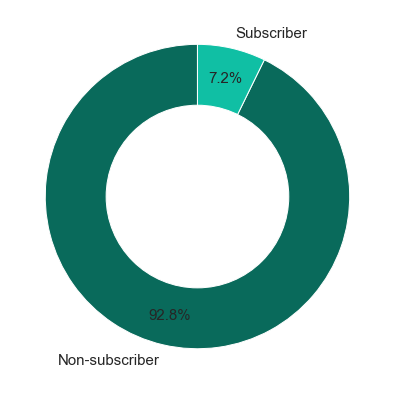

In [45]:
# Graphing our labelled categories
category_names = ['Non-subscriber', 'Subscriber']
sizes = [non_subscriber, subscriber]
colors = ['#096a5b', '#10bfa4']

plt.figure(figsize = (7, 7))
plt.pie(sizes, labels = category_names, textprops = {'fontsize': 15}, startangle=90, 
        autopct='%1.1f%%', colors = colors, pctdistance=0.8)

center_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

In [46]:
# We want to use lazypredict to test out a vast array of models to see which has the best performance
import lazypredict

In [47]:
# Instantiating LazyClassifier (For Classification Problem.  LazyPredict also has the LazyRegressor for Regression Problems)
from lazypredict.Supervised import LazyClassifier

In [48]:
#creating list of dummy columns
to_get_dummies_for = ['job', 'marital', 'contact', 'month']

#creating dummy variables
df_num = pd.get_dummies(data = df_num, columns= to_get_dummies_for, drop_first= True)  

In [49]:
# Separating target variable and other variables
Y = df_num.y
X = df_num.drop(columns = ['y', 'AgeRange', 'balance_range', 'duration_range'])

In [50]:
# Splitting the data
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.30, random_state=seed_value)

In [51]:
y_train.value_counts()

0    25976
1     2024
Name: y, dtype: int64

In [52]:
y_test.value_counts()

0    11128
1      872
Name: y, dtype: int64

In [53]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(x_train, x_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [03:38<00:00,  7.54s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.89               0.82     0.82      0.91   
DecisionTreeClassifier             0.91               0.70     0.70      0.91   
LinearDiscriminantAnalysis         0.93               0.70     0.70      0.93   
XGBClassifier                      0.94               0.69     0.69      0.93   
LGBMClassifier                     0.94               0.68     0.68      0.93   
LabelPropagation                   0.92               0.65     0.65      0.91   
LabelSpreading                     0.92               0.65     0.65      0.92   
BaggingClassifier                  0.93               0.65     0.65      0.92   
ExtraTreeClassifier                0.91               0.65     0.65      0.91   
AdaBoostClassifier                 0.93               0.64     0.64      0.92   
PassiveAggressiveClassifier 

In [54]:
#creating metric function 

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Subscribed', 'Subscribed'], 
                yticklabels=['Not Subscribed', 'Subscribed'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

**Model Performance**

Our **top 5 best** performing models are **NearestCentroid, DecisionTreeClassifier, LinearDiscriminantAnalysis, XGBClassifier and  LGBMClassifier**.  We will develope these models in depth.  LabelPropagation and LabelSpreading also performed well but it did poorly in speed, so we chose to drop these out.  Let's also develop **QuadraticDiscriminantAnalysis, Perceptron and PassiveAggressiveClassifier** because these also came out high in some iterations.

In [55]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import NearestCentroid
import lightgbm as lgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### Perceptron Classifier

In [56]:
# Building perceptron classifier
perc_clf = Perceptron()

In [57]:
# fitting perceptron classifier
perc_clf.fit(x_train, y_train)

Perceptron()

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     25976
           1       0.36      0.56      0.43      2024

    accuracy                           0.89     28000
   macro avg       0.66      0.74      0.69     28000
weighted avg       0.92      0.89      0.91     28000



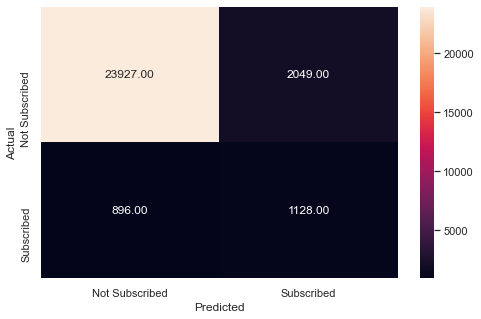

In [58]:
# checking performance on train dataset
y_train_pred_perc = perc_clf.predict(x_train)
metrics_score(y_train, y_train_pred_perc)

**Note:**
We want to focus on predicting subscribers since we have such an imbalanced class.  So in this cash we will want a higher recall score on class 1.  Our model is at a **56% recall** score out of the box.  We could see that we inaccurately misclassed 896 subscribers as non-subscribers and we want to lower this to make our model more effective. Let's see how we do on our test set. 

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     11128
           1       0.35      0.57      0.44       872

    accuracy                           0.89     12000
   macro avg       0.66      0.74      0.69     12000
weighted avg       0.92      0.89      0.90     12000



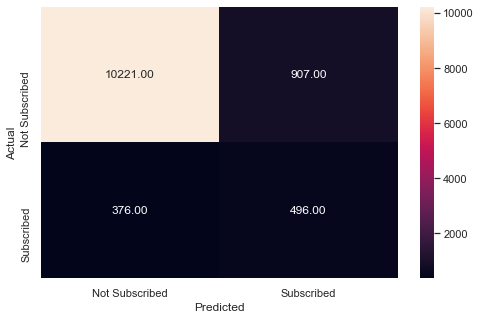

In [59]:
# checking performance on test dataset
y_test_pred_perc = perc_clf.predict(x_test)
metrics_score(y_test, y_test_pred_perc)

**Test Scores**
We get **57% recall** score out of the box.  Slightly better but not great.  

### Adjusting the Class Weight
We will adjust the **class weight** in order to **penalize the misclassification** by the minority class.  Class weight can be derived from the formula:

**weight[i] = n_samples / (n_classes * n_samples[i])**, in our case, for the training set:

- weight of class 0 = 28000 / ( 2 * 25976 ) = 0.53
- weight of class 1 = 28000 / ( 2 * 2024 ) = 6.91

This is what the **'balanced'** class weight will calculate for us.  We'll start with this to see if we get an improved recall score.

In [60]:
# Adjusting for class weight
weight = 'balanced'

In [61]:
# Building perceptron classifier
perc_clf = Perceptron(class_weight=weight)

In [62]:
# fitting perceptron classifier
perc_clf.fit(x_train, y_train)

Perceptron(class_weight='balanced')

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     25976
           1       0.31      0.58      0.40      2024

    accuracy                           0.87     28000
   macro avg       0.64      0.74      0.67     28000
weighted avg       0.92      0.87      0.89     28000



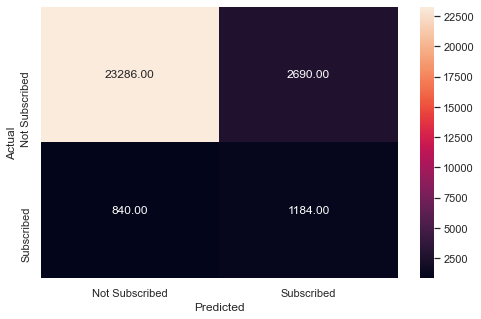

In [63]:
# checking performance on train dataset
y_train_pred_perc = perc_clf.predict(x_train)
metrics_score(y_train, y_train_pred_perc)

**Applying class weight:**

The recall score **improved by 2%** to **58%** score out of the box.  

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     11128
           1       0.30      0.60      0.40       872

    accuracy                           0.87     12000
   macro avg       0.64      0.75      0.67     12000
weighted avg       0.92      0.87      0.89     12000



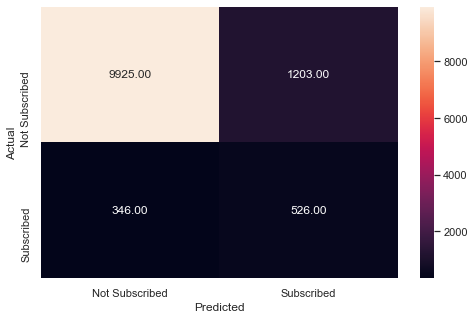

In [64]:
# checking performance on test dataset
y_test_pred_perc = perc_clf.predict(x_test)
metrics_score(y_test, y_test_pred_perc)

**Test Scores**

Improved 3% to a **60% recall**. Slightly better still not great.  

Let's see if we could **manually** find the adjust class weight.  

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   14.5s finished


Text(0.5, 1.0, 'Scoring for different class weights')

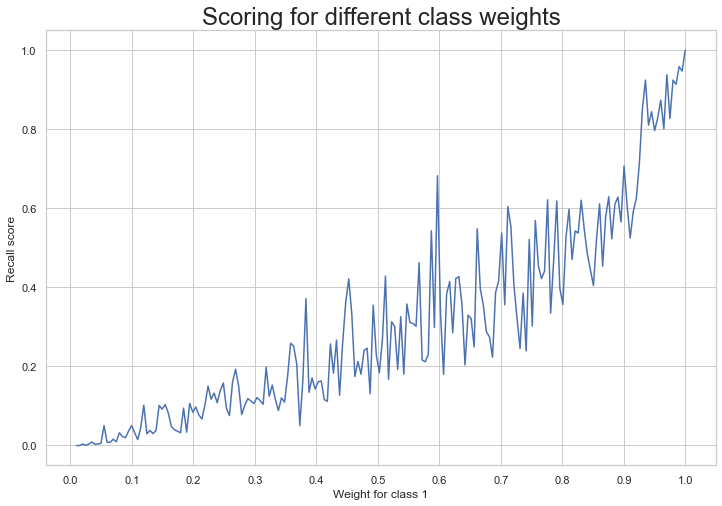

In [65]:
# building a plot to find optimal class weight for better recall scores
from sklearn.model_selection import GridSearchCV, StratifiedKFold
perc_clf = Perceptron()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= perc_clf, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='recall', 
                          verbose=2).fit(x_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('Recall score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

**Manually adjusting the class weight**

We could see that the recall score gets progressive better as we get around .9 and 1.  Looks like it begins to stabilizes around .94

In [66]:
# Adjusting the weight
weight={0: 0.06, 1: 0.94}

In [67]:
# Building perceptron classifier
perc_clf = Perceptron(class_weight=weight)

In [68]:
# fitting perceptron classifier
perc_clf.fit(x_train, y_train)

Perceptron(class_weight={0: 0.06, 1: 0.94})

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     25976
           1       0.26      0.69      0.37      2024

    accuracy                           0.83     28000
   macro avg       0.61      0.77      0.64     28000
weighted avg       0.92      0.83      0.86     28000



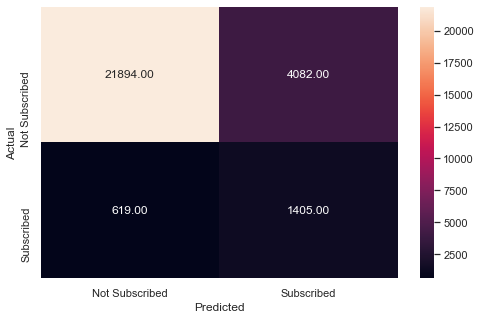

In [69]:
# checking performance on train dataset
y_train_pred_perc = perc_clf.predict(x_train)
metrics_score(y_train, y_train_pred_perc)

**Applying manual class weight:**

The recall score **improved another by 11%** to **69%**.  This is impressive.  

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     11128
           1       0.26      0.72      0.38       872

    accuracy                           0.83     12000
   macro avg       0.62      0.78      0.64     12000
weighted avg       0.92      0.83      0.86     12000



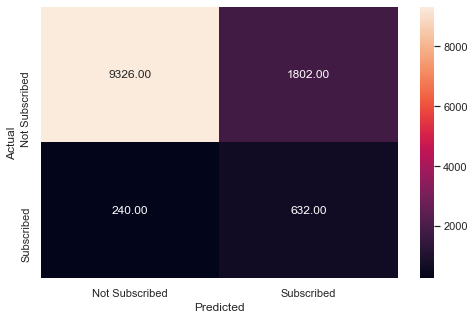

In [70]:
# checking performance on test dataset
y_test_pred_perc = perc_clf.predict(x_test)
metrics_score(y_test, y_test_pred_perc)

**Test Scores**

**Improved and additional 12%** to a **72% recall**. Also impressive.    

Let's continue with the **rest of the models** and see if we get **better results** from these.  

### PassiveAggressiveClassifier Classifier

In [71]:
# instantiating the passive agressive classifier
pa_clf = PassiveAggressiveClassifier(class_weight=weight)

In [72]:
# fitting the passive agressive classifier
pa_clf.fit(x_train, y_train)

PassiveAggressiveClassifier(class_weight={0: 0.06, 1: 0.94})

              precision    recall  f1-score   support

           0       1.00      0.20      0.33     25976
           1       0.09      0.99      0.16      2024

    accuracy                           0.26     28000
   macro avg       0.54      0.59      0.25     28000
weighted avg       0.93      0.26      0.32     28000



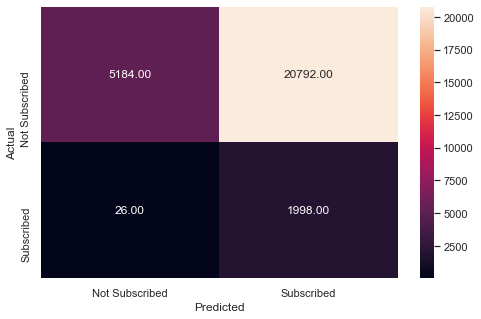

In [73]:
# checking performance on train dataset
y_train_pred_pa = pa_clf.predict(x_train)
metrics_score(y_train, y_train_pred_pa)

              precision    recall  f1-score   support

           0       1.00      0.20      0.33     11128
           1       0.09      0.99      0.16       872

    accuracy                           0.25     12000
   macro avg       0.54      0.59      0.25     12000
weighted avg       0.93      0.25      0.32     12000



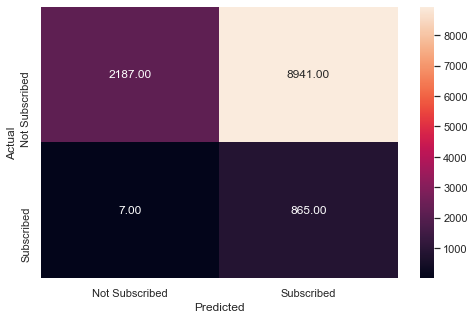

In [74]:
# checking performance on test dataset
y_test_pred_pa = pa_clf.predict(x_test)
metrics_score(y_test, y_test_pred_pa)

### NearestCentroid Classifier

In [75]:
# instantiating the nearest neighbor classifier
nc_clf = NearestCentroid(metric='euclidean')

In [76]:
# fitting nearest centroid classifier
nc_clf.fit(x_train, y_train)

NearestCentroid()

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     25976
           1       0.14      0.41      0.21      2024

    accuracy                           0.77     28000
   macro avg       0.54      0.60      0.54     28000
weighted avg       0.89      0.77      0.82     28000



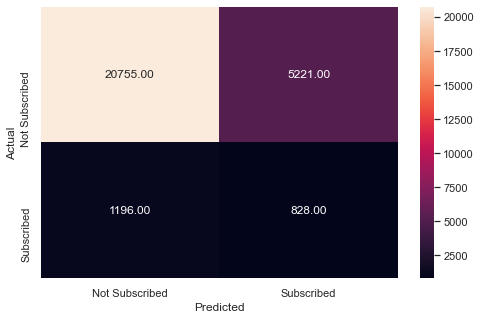

In [77]:
# checking performance on train dataset
y_train_pred_nc = nc_clf.predict(x_train)
metrics_score(y_train, y_train_pred_nc)

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     11128
           1       0.15      0.42      0.22       872

    accuracy                           0.78     12000
   macro avg       0.55      0.62      0.54     12000
weighted avg       0.89      0.78      0.82     12000



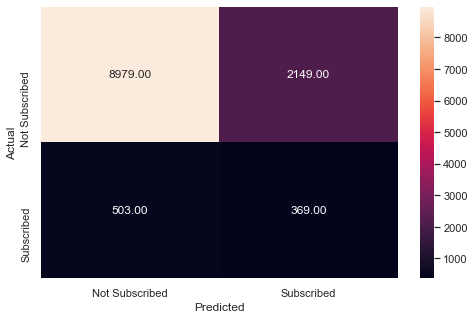

In [78]:
# checking performance on test dataset
y_test_pred_nc = nc_clf.predict(x_test)
metrics_score(y_test, y_test_pred_nc)

### LGBMClassifier Classifier

In [79]:
# instantiating the LGBM classifier
lgb_clf = lgb.LGBMClassifier(class_weight=weight)

In [80]:
# fitting lgb classifier
lgb_clf.fit(x_train, y_train)

LGBMClassifier(class_weight={0: 0.06, 1: 0.94})

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     25976
           1       0.40      0.99      0.57      2024

    accuracy                           0.89     28000
   macro avg       0.70      0.94      0.76     28000
weighted avg       0.96      0.89      0.91     28000



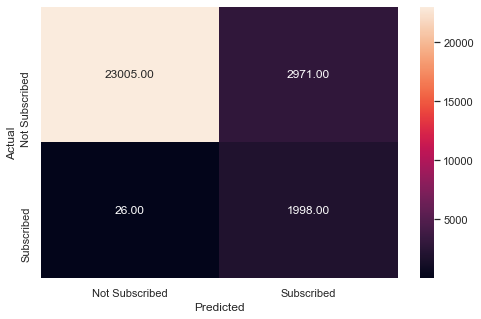

In [81]:
# checking performance on train dataset
y_train_pred_lgb = lgb_clf.predict(x_train)
metrics_score(y_train, y_train_pred_lgb)

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     11128
           1       0.38      0.91      0.53       872

    accuracy                           0.88     12000
   macro avg       0.68      0.90      0.73     12000
weighted avg       0.95      0.88      0.90     12000



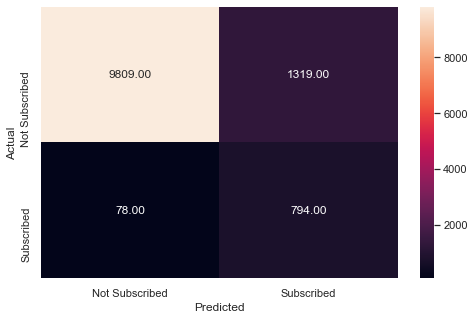

In [82]:
# checking performance on test dataset
y_test_pred_lgb = lgb_clf.predict(x_test)
metrics_score(y_test, y_test_pred_lgb)

## **Test Scores**

The **LGBMClassifier** performs extremely well.  At **99% recall score** on the training set and **91%** recall score on the **test** set.  It does not appear to be overfitting.   This is our **best performing** model so far.  

### LinearDiscriminantAnalysis Classifier

In [83]:
# instantiating the lda classifier
lda_clf = LinearDiscriminantAnalysis()

In [84]:
# fitting lda classifier
lda_clf.fit(x_train, y_train)

LinearDiscriminantAnalysis()

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     25976
           1       0.55      0.43      0.48      2024

    accuracy                           0.93     28000
   macro avg       0.75      0.70      0.72     28000
weighted avg       0.93      0.93      0.93     28000



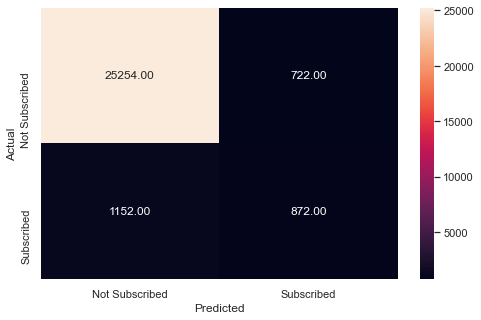

In [85]:
# checking performance on train dataset
y_train_pred_lda = lda_clf.predict(x_train)
metrics_score(y_train, y_train_pred_lda)

### XGBClassifier Classifier

In [86]:
# instantiating the xgb classifier
xgb_clf = xgb.XGBClassifier(class_weight=weight)

In [87]:
# fitting xgb classifier
xgb_clf.fit(x_train, y_train)

[17:54:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', class_weight={0: 0.06, 1: 0.94},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     25976
           1       0.93      0.73      0.82      2024

    accuracy                           0.98     28000
   macro avg       0.96      0.86      0.90     28000
weighted avg       0.98      0.98      0.98     28000



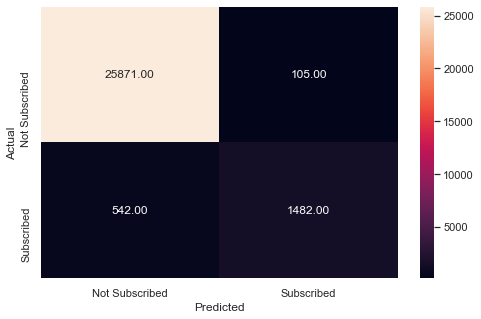

In [88]:
# checking performance on train dataset
y_train_pred_xgb = xgb_clf.predict(x_train)
metrics_score(y_train, y_train_pred_xgb)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     11128
           1       0.59      0.41      0.48       872

    accuracy                           0.94     12000
   macro avg       0.77      0.69      0.72     12000
weighted avg       0.93      0.94      0.93     12000



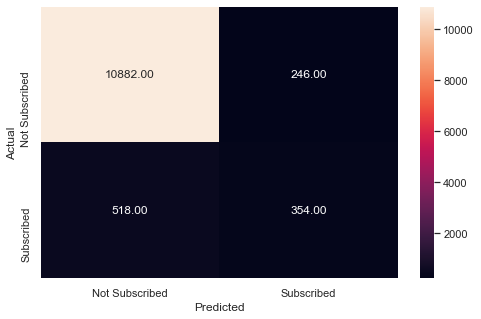

In [89]:
# checking performance on test dataset
y_test_pred_xgb = xgb_clf.predict(x_test)
metrics_score(y_test, y_test_pred_xgb)

### DecisionTreeClassifier Classifier

In [90]:
# instantiating the lda classifier
dt_clf = DecisionTreeClassifier(class_weight=weight)

In [91]:
# fitting decision tree
dt_clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.06, 1: 0.94})

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25976
           1       1.00      1.00      1.00      2024

    accuracy                           1.00     28000
   macro avg       1.00      1.00      1.00     28000
weighted avg       1.00      1.00      1.00     28000



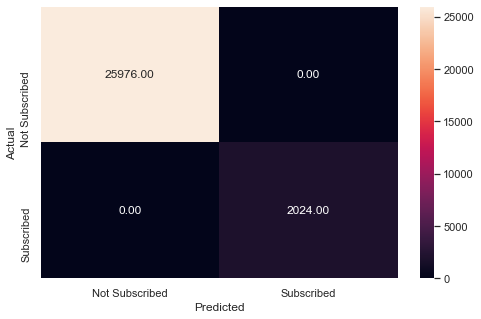

In [92]:
# checking performance on train dataset
y_train_pred_dt = dt_clf.predict(x_train)
metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     11128
           1       0.43      0.37      0.40       872

    accuracy                           0.92     12000
   macro avg       0.69      0.67      0.68     12000
weighted avg       0.91      0.92      0.92     12000



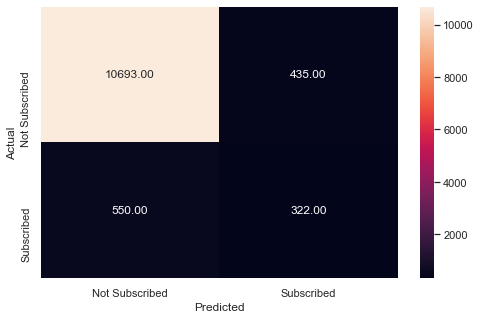

In [93]:
# checking performance on test dataset
y_test_pred_dt = dt_clf.predict(x_test)
metrics_score(y_test, y_test_pred_dt)

### QuadraticDiscriminantAnalysis Classifier

In [94]:
# instantiating the qda classifier
qda_clf = QuadraticDiscriminantAnalysis()

In [95]:
# fitting qda classifier
qda_clf.fit(x_train, y_train)

QuadraticDiscriminantAnalysis()

              precision    recall  f1-score   support

           0       0.99      0.04      0.07     25976
           1       0.07      1.00      0.14      2024

    accuracy                           0.11     28000
   macro avg       0.53      0.52      0.10     28000
weighted avg       0.93      0.11      0.08     28000



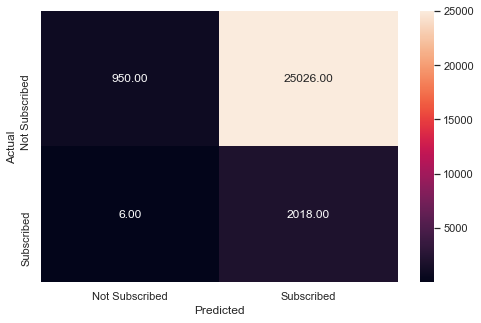

In [96]:
# checking performance on train dataset
y_train_pred_qda = qda_clf.predict(x_train)
metrics_score(y_train, y_train_pred_qda)

              precision    recall  f1-score   support

           0       0.99      0.03      0.07     11128
           1       0.07      1.00      0.14       872

    accuracy                           0.10     12000
   macro avg       0.53      0.52      0.10     12000
weighted avg       0.93      0.10      0.07     12000



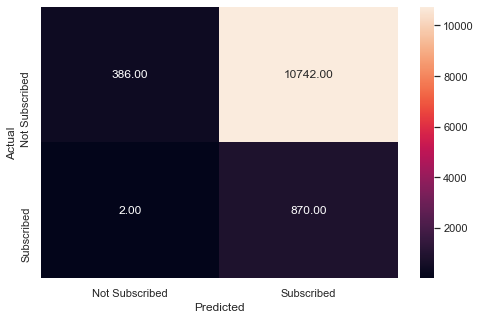

In [97]:
# checking performance on test dataset
y_test_pred_qda = qda_clf.predict(x_test)
metrics_score(y_test, y_test_pred_qda)

### LGBMClassifier Classifier

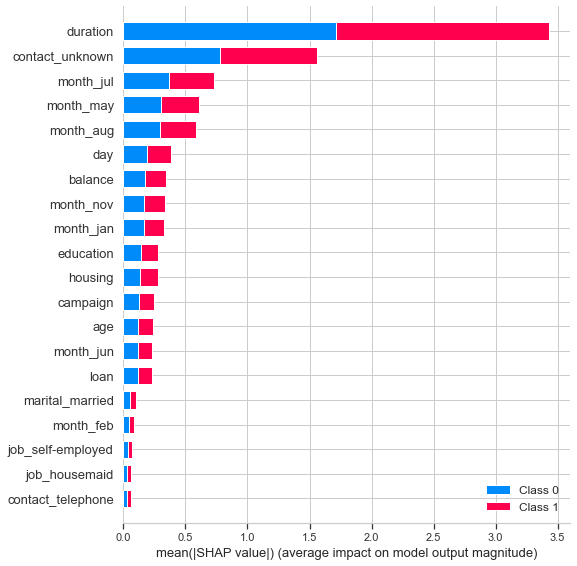

In [98]:
import shap
explainer = shap.TreeExplainer(lgb_clf)
shap_values = explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train)